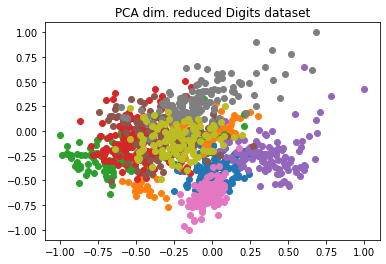

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9}


KeyboardInterrupt: 

In [63]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.multiclass_extensions import OneAgainstRest
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.ml.datasets import ad_hoc_data, sample_ad_hoc_data
from qiskit.ml.datasets import digits


seed= 42
feature_dim = 9
sample_total, training_input, test_input, class_labels = digits(
    training_size=200,
    test_size=10,
    n=9,
    plot_data=True
)
#extra_test_data = sample_ad_hoc_data(training_input, 10, n=feature_dim)
datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
#datapoints, class_to_label = split_dataset_to_data_and_labels(sample_total)
print(class_to_label)
aqua_globals.random_seed = seed


feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=10, entanglement='full')
qsvm = QSVM(
    feature_map,
    training_input,
    test_input,
    datapoints[0],
    OneAgainstRest()
)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

print(f'Testing success ratio: {result["testing_accuracy"]}')
print()
print('Prediction from datapoints set:')
print(f'  ground truth: {map_label_to_class_name(datapoints[1], qsvm.label_to_class)}')
print(f'  prediction:   {result["predicted_classes"]}')
predicted_labels = result["predicted_labels"]
print(f'  success rate: {100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)}%')

In [ ]:
 training_input

In [ ]:
import matplotlib.pyplot as plt 
plt.gray() 
plt.matshow(digits.images[2]) 
plt.show()

In [ ]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2018, 2021.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""The Quantum SVM algorithm."""

from typing import Dict, Optional, Union
import warnings
import logging
import sys

import numpy as np
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.tools import parallel_map
from qiskit.tools.events import TextProgressBar
from qiskit.circuit import ParameterVector
from qiskit.providers import BaseBackend
from qiskit.providers import Backend
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QuantumAlgorithm
from qiskit.aqua import AquaError
from qiskit.aqua.utils.dataset_helper import get_num_classes
from qiskit.aqua.utils import split_dataset_to_data_and_labels
from qiskit.aqua.components.feature_maps import FeatureMap
from qiskit.aqua.components.multiclass_extensions import MulticlassExtension
from qiskit.aqua.components.multiclass_extensions import OneAgainstRest
from ._qsvm_estimator import _QSVM_Estimator
from ._qsvm_binary import _QSVM_Binary
from ._qsvm_multiclass import _QSVM_Multiclass


class EquivariantQSVM(QuantumAlgorithm):
    """Equivariant Quantum SVM algorithm.

    A key concept in classification methods is that of a kernel. Data cannot typically be
    separated by a hyperplane in its original space. A common technique used to find such a
    hyperplane consists on applying a non-linear transformation function to the data.
    This function is called a *feature map*, as it transforms the raw features, or measurable
    properties, of the phenomenon or subject under study. Classifying in this new feature space
    – and, as a matter of fact, also in any other space, including the raw original one – is
    nothing more than seeing how close data points are to each other. This is the same as
    computing the inner product for each pair of data in the set. In fact we do not need to
    compute the non-linear feature map for each datum, but only the inner product of each pair
    of data points in the new feature space. This collection of inner products is called the
    **kernel** and it is perfectly possible to have feature maps that are hard to compute but
    whose kernels are not.

    The QSVM algorithm applies to classification problems that require a feature map for which
    computing the kernel is not efficient classically. This means that the required computational
    resources are expected to scale exponentially with the size of the problem.
    QSVM uses a Quantum processor to solve this problem by a direct estimation of the kernel in
    the feature space. The method used falls in the category of what is called
    **supervised learning**, consisting of a **training phase** (where the kernel is calculated
    and the support vectors obtained) and a **test or classification phase** (where new data
    without labels is classified according to the solution found in the training phase).

    Internally, QSVM will run the binary classification or multiclass classification
    based on how many classes the data has. If the data has more than 2 classes then a
    *multiclass_extension* is required to be supplied. Aqua provides several
    :mod:`~qiskit.aqua.components.multiclass_extensions`.

    See also https://arxiv.org/abs/1804.11326
    """

    BATCH_SIZE = 1000

    def __init__(self, feature_map: Union[QuantumCircuit, FeatureMap],
                 training_dataset: Optional[Dict[str, np.ndarray]] = None,
                 test_dataset: Optional[Dict[str, np.ndarray]] = None,
                 datapoints: Optional[np.ndarray] = None,
                 multiclass_extension: Optional[MulticlassExtension] = None,
                 lambda2: float = 0.001,
                 quantum_instance: Optional[
                     Union[QuantumInstance, BaseBackend, Backend]] = None) -> None:
        """
        Args:
            feature_map: Feature map module, used to transform data
            training_dataset: Training dataset.
            test_dataset: Testing dataset.
            datapoints: Prediction dataset.
            multiclass_extension: If number of classes is greater than 2 then a multiclass scheme
                must be supplied, in the form of a multiclass extension.
            lambda2: L2 norm regularization factor
            quantum_instance: Quantum Instance or Backend

        Raises:
            AquaError: Multiclass extension not supplied when number of classes > 2
        """
        super().__init__(quantum_instance)

        # check the validity of provided arguments if possible

        self.training_dataset = None
        self.test_dataset = None
        self.datapoints = None
        self.class_to_label = None
        self.label_to_class = None
        self.num_classes = None

        self.setup_training_data(training_dataset)
        self.setup_test_data(test_dataset)
        self.setup_datapoint(datapoints)
        self.lambda2 = lambda2

        self.feature_map = feature_map
        self.num_qubits = self.feature_map.num_qubits

        if isinstance(feature_map, QuantumCircuit):
            # patch the feature dimension attribute to the circuit
            self.feature_map.feature_dimension = len(feature_map.parameters)
            if not hasattr(feature_map, 'ordered_parameters'):
                self.feature_map.ordered_parameters = sorted(feature_map.parameters,
                                                             key=lambda p: p.name)
            self.feature_map_params_x = ParameterVector('x', self.feature_map.feature_dimension)
            self.feature_map_params_y = ParameterVector('y', self.feature_map.feature_dimension)
        else:
            self.feature_map_params_x = ParameterVector('x', feature_map.feature_dimension)
            self.feature_map_params_y = ParameterVector('y', feature_map.feature_dimension)


        multiclass_extension.set_estimator(_QSVM_Estimator, [feature_map])
        self.instance = _QSVM_Multiclass(self, multiclass_extension)



    @staticmethod
    def _construct_circuit(x, feature_map, measurement, is_statevector_sim=False):
        """If `is_statevector_sim` is True, we only build the circuits for Psi(x1)|0> rather than
        Psi(x2)^dagger Psi(x1)|0>.
        """
        x1, x2 = x
        if len(x1) != len(x2):
            raise ValueError("x1 and x2 must be the same dimension.")

        q = QuantumRegister(feature_map.num_qubits, 'q')
        c = ClassicalRegister(feature_map.num_qubits, 'c')
        qc = QuantumCircuit(q, c)

        # write input state from sample distribution
        if isinstance(feature_map, FeatureMap):
            qc.append(feature_map.construct_circuit(x1, q).to_instruction(), qc.qubits)
        else:
            psi_x1 = _assign_parameters(feature_map, x1)
            qc.append(psi_x1.to_instruction(), qc.qubits)

        if not is_statevector_sim:
            # write input state from sample distribution
            if isinstance(feature_map, FeatureMap):
                qc.append(feature_map.construct_circuit(x2, q).inverse().to_instruction(),
                          qc.qubits)
            else:
                psi_x2_dag = _assign_parameters(feature_map, x2)
                qc.append(psi_x2_dag.to_instruction().inverse(), qc.qubits)

            if measurement:
                qc.barrier(q)
                qc.measure(q, c)
        return qc

    @staticmethod
    def _compute_overlap(idx, results, is_statevector_sim, measurement_basis):
        if is_statevector_sim:
            i, j = idx
            # TODO: qiskit-terra did not support np.int64 to lookup result
            v_a = results.get_statevector(int(i))
            v_b = results.get_statevector(int(j))
            # |<0|Psi^daggar(y) x Psi(x)|0>|^2, take the amplitude
            tmp = np.vdot(v_a, v_b)
            kernel_value = np.vdot(tmp, tmp).real  # pylint: disable=no-member
        else:
            result = results.get_counts(idx)
            kernel_value = result.get(measurement_basis, 0) / sum(result.values())
        return kernel_value

    def construct_circuit(self, x1, x2, measurement=False):
        """
        Generate inner product of x1 and x2 with the given feature map.

        The dimension of x1 and x2 must be the same.

        Args:
            x1 (numpy.ndarray): data points, 1-D array, dimension is D
            x2 (numpy.ndarray): data points, 1-D array, dimension is D
            measurement (bool): add measurement gates at the end
        Returns:
            QuantumCircuit: constructed circuit
        """
        return QSVM._construct_circuit((x1, x2), self.feature_map, measurement)


    @staticmethod
    def get_kernel_matrix(quantum_instance,
                          feature_map,
                          x1_vec,
                          GroupAction=None
                          x2_vec=None,
                          enforce_psd=True):
        """
        Construct kernel matrix, if x2_vec is None, self-innerproduct is conducted.

        Notes:
            When using `statevector_simulator`,
            we only build the circuits for Psi(x1)|0> rather than
            Psi(x2)^dagger Psi(x1)|0>, and then we perform the inner product classically.
            That is, for `statevector_simulator`,
            the total number of circuits will be O(N) rather than
            O(N^2) for `qasm_simulator`.

        Args:
            quantum_instance (QuantumInstance): quantum backend with all settings
            feature_map (FeatureMap): a feature map that maps data to feature space
            x1_vec (numpy.ndarray): data points, 2-D array, N1xD, where N1 is the number of data,
                                    D is the feature dimension
            x2_vec (numpy.ndarray): data points, 2-D array, N2xD, where N2 is the number of data,
                                    D is the feature dimension
            enforce_psd (bool): enforces that the kernel matrix is positive semi-definite by setting
                                negative eigenvalues to zero. This is only applied in the symmetric
                                case, i.e., if `x2_vec == None`.
        Returns:
            numpy.ndarray: 2-D matrix, N1xN2
        """

        if isinstance(feature_map, QuantumCircuit):
            use_parameterized_circuits = True
        else:
            use_parameterized_circuits = feature_map.support_parameterized_circuit

        if x2_vec is None:
            is_symmetric = True
            x2_vec = x1_vec
        else:
            is_symmetric = False

        is_statevector_sim = quantum_instance.is_statevector

        measurement = not is_statevector_sim
        measurement_basis = '0' * feature_map.num_qubits
        mat = np.ones((x1_vec.shape[0], x2_vec.shape[0]))

        # get all indices
        if is_symmetric:
            mus, nus = np.triu_indices(x1_vec.shape[0], k=1)  # remove diagonal term
        else:
            mus, nus = np.indices((x1_vec.shape[0], x2_vec.shape[0]))
            mus = np.asarray(mus.flat)
            nus = np.asarray(nus.flat)

        if is_statevector_sim:
            if is_symmetric:
                to_be_computed_data = x1_vec
            else:
                to_be_computed_data = np.concatenate((x1_vec, x2_vec))

            if use_parameterized_circuits:
                # build parameterized circuits, it could be slower for building circuit
                # but overall it should be faster since it only transpile one circuit
                feature_map_params = ParameterVector('x', feature_map.feature_dimension)
                parameterized_circuit = QSVM._construct_circuit(
                    (feature_map_params, feature_map_params), feature_map, measurement,
                    is_statevector_sim=is_statevector_sim)
                parameterized_circuit = quantum_instance.transpile(parameterized_circuit)[0]
                circuits = [parameterized_circuit.assign_parameters({feature_map_params: x})
                            for x in to_be_computed_data]
            else:
                #  the second x is redundant
                to_be_computed_data_pair = [(x, x) for x in to_be_computed_data]
                if logger.isEnabledFor(logging.DEBUG):
                    logger.debug("Building circuits:")
                    TextProgressBar(sys.stderr)
                circuits = parallel_map(QSVM._construct_circuit,
                                        to_be_computed_data_pair,
                                        task_args=(feature_map, measurement, is_statevector_sim),
                                        num_processes=aqua_globals.num_processes)

            results = quantum_instance.execute(circuits,
                                               had_transpiled=use_parameterized_circuits)

            if logger.isEnabledFor(logging.DEBUG):
                logger.debug("Calculating overlap:")
                TextProgressBar(sys.stderr)

            offset = 0 if is_symmetric else len(x1_vec)
            matrix_elements = parallel_map(QSVM._compute_overlap, list(zip(mus, nus + offset)),
                                           task_args=(results,
                                                      is_statevector_sim, measurement_basis),
                                           num_processes=aqua_globals.num_processes)

            for i, j, value in zip(mus, nus, matrix_elements):
                mat[i, j] = value
                if is_symmetric:
                    mat[j, i] = mat[i, j]
        else:
            for idx in range(0, len(mus), QSVM.BATCH_SIZE):
                to_be_computed_data_pair = []
                to_be_computed_index = []
                for sub_idx in range(idx, min(idx + QSVM.BATCH_SIZE, len(mus))):
                    i = mus[sub_idx]
                    j = nus[sub_idx]
                    x1 = x1_vec[i]
                    x2 = x2_vec[j]
                    if not np.all(x1 == x2):
                        to_be_computed_data_pair.append((x1, x2))
                        to_be_computed_index.append((i, j))

                if use_parameterized_circuits:
                    # build parameterized circuits, it could be slower for building circuit
                    # but overall it should be faster since it only transpile one circuit
                    feature_map_params_x = ParameterVector('x', feature_map.feature_dimension)
                    feature_map_params_y = ParameterVector('y', feature_map.feature_dimension)
                    parameterized_circuit = QSVM._construct_circuit(
                        (feature_map_params_x, feature_map_params_y), feature_map, measurement,
                        is_statevector_sim=is_statevector_sim)
                    parameterized_circuit = quantum_instance.transpile(parameterized_circuit)[0]
                    circuits = [parameterized_circuit.assign_parameters({feature_map_params_x: x,
                                                                         feature_map_params_y: y})
                                for x, y in to_be_computed_data_pair]
                else:
                    if logger.isEnabledFor(logging.DEBUG):
                        logger.debug("Building circuits:")
                        TextProgressBar(sys.stderr)
                    circuits = parallel_map(QSVM._construct_circuit,
                                            to_be_computed_data_pair,
                                            task_args=(feature_map, measurement),
                                            num_processes=aqua_globals.num_processes)

                results = quantum_instance.execute(circuits,
                                                   had_transpiled=use_parameterized_circuits)

                if logger.isEnabledFor(logging.DEBUG):
                    logger.debug("Calculating overlap:")
                    TextProgressBar(sys.stderr)
                matrix_elements = parallel_map(QSVM._compute_overlap, range(len(circuits)),
                                               task_args=(results,
                                                          is_statevector_sim, measurement_basis),
                                               num_processes=aqua_globals.num_processes)

                for (i, j), value in zip(to_be_computed_index, matrix_elements):
                    mat[i, j] = value
                    if is_symmetric:
                        mat[j, i] = mat[i, j]

        if enforce_psd and is_symmetric and not is_statevector_sim:
            # Find the closest positive semi-definite approximation to kernel matrix, in case it is
            # symmetric. The (symmetric) matrix should always be positive semi-definite by
            # construction, but this can be violated in case of noise, such as sampling noise, thus,
            # the adjustment is only done if NOT using the statevector simulation.
            D, U = np.linalg.eig(mat)
            mat = U @ np.diag(np.maximum(0, D)) @ U.transpose()

        return mat


    def construct_kernel_matrix(self, x1_vec, x2_vec=None, quantum_instance=None):
        """
        Construct kernel matrix, if x2_vec is None, self-innerproduct is conducted.

        Notes:
            When using `statevector_simulator`, we only build
            the circuits for Psi(x1)|0> rather than
            Psi(x2)^dagger Psi(x1)|0>, and then we perform the inner product classically.
            That is, for `statevector_simulator`, the total number
            of circuits will be O(N) rather than
            O(N^2) for `qasm_simulator`.

        Args:
            x1_vec (numpy.ndarray): data points, 2-D array, N1xD, where N1 is the number of data,
                                    D is the feature dimension
            x2_vec (numpy.ndarray): data points, 2-D array, N2xD, where N2 is the number of data,
                                    D is the feature dimension
            quantum_instance (QuantumInstance): quantum backend with all settings

        Returns:
            numpy.ndarray: 2-D matrix, N1xN2

        Raises:
            AquaError: Quantum instance is not present.
        """
        self._quantum_instance = self._quantum_instance \
            if quantum_instance is None else quantum_instance
        if self._quantum_instance is None:
            raise AquaError("Either setup quantum instance or provide it in the parameter.")

        return QSVM.get_kernel_matrix(self._quantum_instance, self.feature_map, x1_vec, x2_vec)


    def train(self, data, labels, quantum_instance=None):
        """
        Train the svm.

        Args:
            data (numpy.ndarray): NxD array, where N is the number of data,
                                  D is the feature dimension.
            labels (numpy.ndarray): Nx1 array, where N is the number of data
            quantum_instance (QuantumInstance): quantum backend with all setting

        Raises:
            AquaError: Quantum instance is not present.
        """
        self._quantum_instance = self._quantum_instance \
            if quantum_instance is None else quantum_instance
        if self._quantum_instance is None:
            raise AquaError("Either setup quantum instance or provide it in the parameter.")
        self.instance.train(data, labels)


    def test(self, data, labels, quantum_instance=None):
        """
        Test the svm.

        Args:
            data (numpy.ndarray): NxD array, where N is the number of data,
                                  D is the feature dimension.
            labels (numpy.ndarray): Nx1 array, where N is the number of data
            quantum_instance (QuantumInstance): quantum backend with all setting

        Returns:
            float: accuracy

        Raises:
            AquaError: Quantum instance is not present.
        """

        self._quantum_instance = self._quantum_instance \
            if quantum_instance is None else quantum_instance
        if self._quantum_instance is None:
            raise AquaError("Either setup quantum instance or provide it in the parameter.")
        return self.instance.test(data, labels)


    def predict(self, data, quantum_instance=None):
        """
        Predict using the svm.

        Args:
            data (numpy.ndarray): NxD array, where N is the number of data,
                                  D is the feature dimension.
            quantum_instance (QuantumInstance): quantum backend with all setting

        Returns:
            numpy.ndarray: predicted labels, Nx1 array

        Raises:
            AquaError: Quantum instance is not present.
        """
        self._quantum_instance = self._quantum_instance \
            if quantum_instance is None else quantum_instance
        if self._quantum_instance is None:
            raise AquaError("Either setup quantum instance or provide it in the parameter.")
        return self.instance.predict(data)

In [ ]:
import sys
!{sys.executable} -m pip install cvxpy